# Training AU visualization model
You will first need to gather the datasets for training. In this tutorial we use the datasets EmotioNet, DISFA Plus, and BP4d. After you download each model you should extract the labels and landmarks from each dataset. Detailed code on how to do that is described at the bottom of this tutorial. Once you have the labels and landmark files for each dataset you can train the AU visualization model with the following. 

In [98]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from feat.plotting import predict, plot_face
from feat.utils import registration, neutral
from natsort import natsorted
import os, glob 
import pandas as pd, numpy as np
import seaborn as sns
sns.set_style("white")

base_dir = "/Storage/Projects/feat_benchmark/scripts/jcheong/openface_train"

labels_emotionet = pd.read_csv(os.path.join(base_dir, "emotionet_labels.csv"))
landmarks_emotionet = pd.read_csv(os.path.join(base_dir, "emotionet_landmarks.csv"))
print("EmotioNet: ", len(labels_emotionet))
labels_disfaplus = pd.read_csv(os.path.join(base_dir, "disfaplus_labels.csv"))
landmarks_disfaplus = pd.read_csv(os.path.join(base_dir, "disfaplus_landmarks.csv"))
# Disfa is rescaled to 0 - 1
disfaplus_aus = [col for col in labels_disfaplus.columns if "AU" in col]
labels_disfaplus[disfaplus_aus] = labels_disfaplus[disfaplus_aus].astype('float')/5
print("DISFA Plus: ", len(labels_disfaplus))
labels_bp4d = pd.read_csv(os.path.join(base_dir, "bp4d_labels.csv"))
landmarks_bp4d = pd.read_csv(os.path.join(base_dir, "bp4d_landmarks.csv"))
bp4d_pruned_idx = labels_bp4d.replace({9: np.nan})[au_cols].dropna(axis=1).index
print("BP4D: ", len(labels_bp4d))

EmotioNet:  24587
DISFA Plus:  57668
BP4D:  143951


We aggregate the datasets and specify the AUs we want to train. 

In [100]:
labels = pd.concat([
                    labels_emotionet.replace({999: np.nan}), 
                    labels_disfaplus,
                    labels_bp4d.replace({9: np.nan}).iloc[bp4d_pruned_idx,:]
                   ]).reset_index(drop=True)
landmarks = pd.concat([
                       landmarks_emotionet, 
                       landmarks_disfaplus,
                       landmarks_bp4d.iloc[bp4d_pruned_idx,:]
                      ]).reset_index(drop=True)

landmarks = landmarks.iloc[labels.index]

au_cols = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 25, 26, 28, 43]
au_cols = [f"AU{au}" for au in au_cols]
labels = labels[au_cols].fillna(0)

We train our model using PLSRegression with a minimum of 500 samples for each AU activation. We evaluate the model in a 3-fold split and retrain the model with all the data which is distributed with the package.

In [115]:
min_pos_sample = 500

print('Pseudo balancing samples')
balY = pd.DataFrame()
balX = pd.DataFrame()
for AU in labels[au_cols].columns:
    if np.sum(labels[AU]==1) > min_pos_sample:
        replace = False
    else:
        replace = True
    newSample = labels[labels[AU]>.5].sample(min_pos_sample, replace=replace, random_state=0)
    balX = pd.concat([balX, newSample])
    balY = pd.concat([balY, landmarks.loc[newSample.index]])
X = balX[au_cols].values
y = registration(balY.values, neutral)

# Model Accuracy in KFold CV
print("Evaluating model with KFold CV")
n_components=len(au_cols)
kf = KFold(n_splits=3)
scores = []
for train_index, test_index in kf.split(X):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf = PLSRegression(n_components=n_components, max_iter=2000)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
print('3-fold accuracy mean', np.round(np.mean(scores),2))

# Train real model
clf = PLSRegression(n_components=n_components, max_iter=2000)
clf.fit(X,y)
print('N_comp:',n_components,'Rsquare', np.round(clf.score(X,y),2))

Pseudo balancing samples
Evaluating model with KFold CV
3-fold accuracy mean 0.13
N_comp: 20 Rsquare 0.15


We visualize the results of our model. The regression was trained on labels 0-1 so we do not recommend exceeding 1 for the intensity. Setting the intensity to 2 will exaggerate the face and anything beyond that might give you strange faces. 

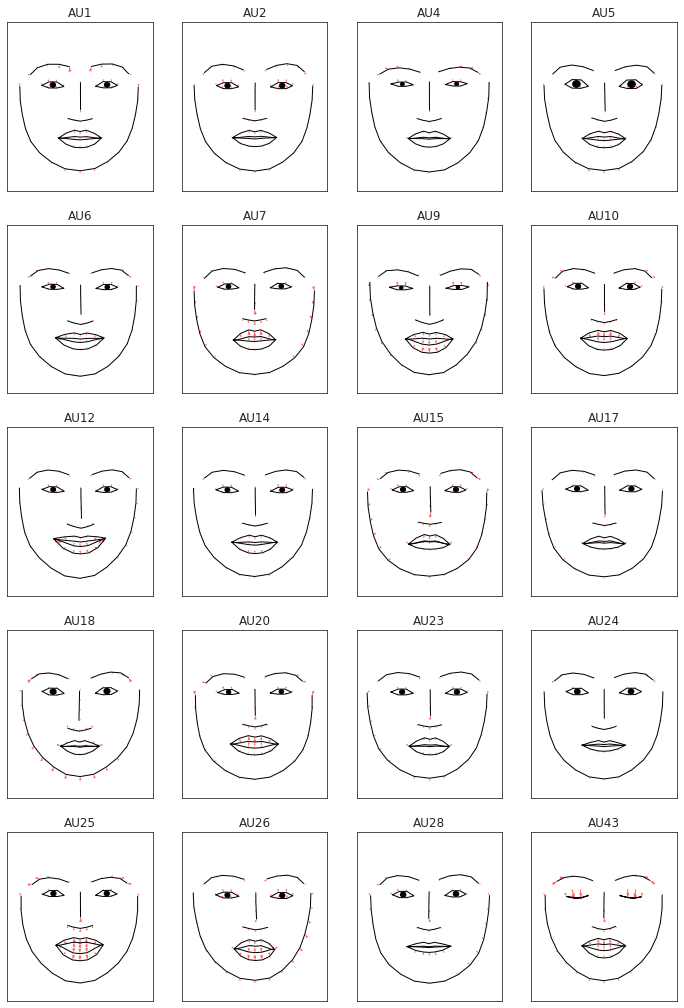

In [116]:
# Plot results for each action unit
f,axes = plt.subplots(5,4,figsize=(12,18))
axes = axes.flatten()
# Exaggerate the intensity of the expression for clearer visualization. 
# We do not recommend exceeding 2. 
intensity = 2
for aui, auname in enumerate(axes):
    try:
        auname=au_cols[aui]
        au = np.zeros(clf.n_components)
        au[aui] = intensity
        predicted = clf.predict([au]).reshape(2,68)
        plot_face(au=au, model=clf,
                  vectorfield={"reference": neutral.T, 'target': predicted,
                               'color':'r','alpha':.6},
                 ax = axes[aui])
        axes[aui].set(title=auname)
    except:
        pass
    finally:
        ax = axes[aui]
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

## Interactive visualization

In [5]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


In [6]:
def f(x):
    return x

interact(f, x=10);


interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

Here is how we would export our model into an h5 format which can be loaded using our load_h5 function. 

In [ ]:
# save out trained model
# import h5py
# hf = h5py.File('../feat/resources/pyfeat_aus_to_landmarks.h5', 'w')
# hf.create_dataset('coef', data=clf.coef_)
# hf.create_dataset('x_mean', data=clf._x_mean)
# hf.create_dataset('x_std', data=clf._x_std)
# hf.create_dataset('y_mean', data=clf._y_mean)
# hf.close()

In [371]:
import pytest
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import os
from feat.tests.utils import get_test_data_path
from feat.data import Fex, Fextractor
from feat.utils import read_facet, read_openface, read_affectiva
from nltools.data import Adjacency
import unittest
filename = os.path.join(get_test_data_path(), "OpenFace_Test.csv")
openface = Fex(filename=filename, sampling_freq=30, detector="OpenFace")
openface = openface.read_file()

aus = openface.aus()
aus.sessions = range(len(aus))
y = aus[[i for i in aus.columns if "_r" in i]]
X = pd.DataFrame(aus.sessions)
b, t, p, df, res = aus.regress(X, y, mode="ols", fit_intercept=True)
assert b.shape == (2, 17)
assert res.mean().mean() < 1

/home/jcheong/anaconda3/lib/python3.8/site-packages/nltools/stats.py:970: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]


In [420]:
a = openface.aus().assign(input = "0")
b = openface.aus().apply(lambda x: x+np.random.rand(100)).assign(input = "1")
doubled = pd.concat([a, b])
doubled.sessions = doubled['input']
t, p = doubled.ttest_ind(col="AU12_r", sessions = ("0", "1"))
assert( t <0)

In [425]:
frame = np.concatenate([np.array(range(int(len(doubled)/2))), np.array(range(int(len(doubled)/2)))])
assert(doubled.assign(frame = frame).isc(col = "AU04_r").iloc[0,0] == 1)

In [423]:
pd.pivot_table(doubled.assign(frame = frame), index = "frame", columns="input", values="AU04_r")

input,0,1
frame,,
0,0.2435,0.740541
1,0.3347,1.146488
2,0.4339,0.554734
3,0.5075,1.313604
4,0.5708,0.906811
...,...,...
95,0.5155,0.930397
96,0.5023,1.257925
97,0.5611,1.210915


In [362]:
setattr(clf_facet, "new_attr", [1,2,3,4])

In [363]:
clf_facet.new_attr

[1, 2, 3, 4]

In [ ]:
clf_facet.y_mean_

In [351]:
clf_facet = load("pls_au_to_landmarks.joblib")

In [ ]:
# Plot results for each action unit
f,axes = plt.subplots(4,5,figsize=(20,16))
axes = axes.flatten()
intensity = 1
for aui, auname in enumerate(au_cols):
    au = np.zeros(clf_facet.n_components)
    au[aui] = intensity
    predicted = clf_facet.predict([au]).reshape(2,68)
    plot_face(au=au, model=clf_facet,
              vectorfield={"reference": neutral.T, 'target': predicted,
                           'color':'r','alpha':.6},
             ax = axes[aui])
#     plot_face(au=np.zeros(n_components), model=clf_facet,
#               vectorfield={"reference": neutral.T, 'target':predicted,
#                            'color':'r','alpha':.6},
#              ax = axes[aui])
#     plot_face(au=au, model=clf_facet, ax = axes[aui])
    axes[aui].set(title=auname)

In [426]:
__version__

'0.23.2'

In [4]:
setattr(PLSRegression,"_x_mean", [1,2,3,4])

In [6]:
PLSRegression.

sklearn.cross_decomposition._pls.PLSRegression

# tiankang data

In [ ]:
bp4d_master = pd.read_csv("/home/tiankang/AU_Dataset/BP4D/BP4D_Concat_MasterFile.csv")
bp4dplus_master = pd.read_csv("/home/tiankang/AU_Dataset/BP4DPlus/BP4D+_Concat_MasterFile.csv")
ckpluspain_master = pd.read_csv("/home/tiankang/AU_Dataset/CKPlus/PAIN_CK_Integrated.csv")
disfa_master = pd.read_csv("/home/tiankang/AU_Dataset/DISFA/DISFA_Concat_MasterFile.csv")
disfaplus_master = pd.read_csv("/home/tiankang/AU_Dataset/DISFAPlus/DISFA+_Concat_MasterFile.csv")

In [334]:
bp4d_master.loc[0, "aligned_path"]

'/Storage/Data/BP4D/Sequences_2D+3D/aligned/F020/T1/846.jpg'

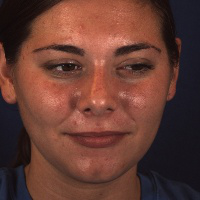

In [337]:
from PIL import Image
img = Image.open(bp4d_master.loc[100, "aligned_path"])
img

In [ ]:
for col in bp4dplus_master.columns:
    if "AU" in col:
        print(col)

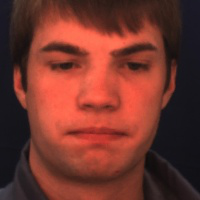

In [340]:
from PIL import Image
img = Image.open(disfa_master.loc[500, "aligned_path"])
img

In [343]:
disfa_master.columns

Index(['Unnamed: 0', 'Dataset', 'original_path', 'aligned_path',
       'aligned_landmark', 'subject', 'frame', 'AU1', 'AU2', 'AU4', 'AU5',
       'AU6', 'AU9', 'AU12', 'AU15', 'AU17', 'AU20', 'AU25', 'AU26'],
      dtype='object')

In [221]:
bp4d_master["AU1"].value_counts()

0    113240
1     30718
Name: AU1, dtype: int64

In [222]:
bp4dplus_master["AU1"].value_counts()

0    177764
1     19079
9       643
Name: AU1, dtype: int64

In [217]:
ckpluspain_master["1"].value_counts()

0.0    415
1.0    173
Name: 1, dtype: int64

In [223]:
disfa_master["AU1"].value_counts()

0    122036
3      2809
1      2272
2      1749
4      1393
5       555
Name: AU1, dtype: int64

In [224]:
disfaplus_master['AU1'].value_counts()

0    47913
2     2568
1     2069
5     1910
3     1747
4      943
Name: AU1, dtype: int64

In [272]:
def split_tk_lms(x):
    lms = x
    lms = lms.replace("\n","").replace("[ ","").replace("]","").split()
    lms = np.array(lms).astype(float)
    return lms

In [274]:
split_tk_lms(ckpluspain_master['aligned_landmark'].iloc[0]).shape

(98,)

In [ ]:
# Delete rows with na and mask each array
labels = pd.concat([disfa_master, disfaplus_master])
landmarks = pd.concat([landmarks_ck, landmarks_emotionet, landmarks_disfaplus]).reset_index(drop=True)


au_cols = [col for col in labels.columns if "AU" in col]
# X = labels[au_cols].values
# y = registration(landmarks.values, neutral)

print('balancing samples')
balY = pd.DataFrame()
balX = pd.DataFrame()
for AU in labels[au_cols].columns:
    newSample = labels[labels[AU]>0].sample(1000, replace=True)
    balX = pd.concat([balX, newSample])
    balY = pd.concat([balY, landmarks.loc[newSample.index]])
X = balX[au_cols].values
y = registration(balY.values, neutral)

print("training model with CV")
# Train model
n_components=np.shape(X)[1]

# Model Accuracy in KFold CV
kf = KFold(n_splits=3)
scores = []
for train_index, test_index in kf.split(X):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf_facet = PLSRegression(n_components=n_components, max_iter=2000)
    clf_facet.fit(X_train,y_train)
    scores.append(clf_facet.score(X_test,y_test))
print('3-fold accuracy mean', np.round(np.mean(scores),2))

# Train real model
clf_facet = PLSRegression(n_components=n_components, max_iter=2000)
clf_facet.fit(X,y)
print('N_comp:',n_components,'Rsquare', np.round(clf_facet.score(X,y),2))


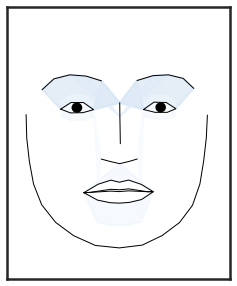

In [149]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from feat.tests.utils import get_test_data_path
from feat import Fex, Detector
from feat.utils import read_openface, read_affectiva
from feat.plotting import plot_face, draw_lineface, draw_vectorfield, predict
import matplotlib
test_file = join(get_test_data_path(), "OpenFace_Test.csv")
_, ax = plt.subplots(figsize=(4, 5))
openface = read_openface(test_file)
ax = openface.plot_aus(12, ax=ax, muscles={"all": "heatmap"}, gaze=None)

In [ ]:
f,ax = plt.subplots()
plt.scatter(neutral_face[:,0], neutral_face[:,1])
ax.axis("square")
ax.set(ylim=[230,80])

[(230.0, 80.0), Text(0.5, 1.0, 'registered')]

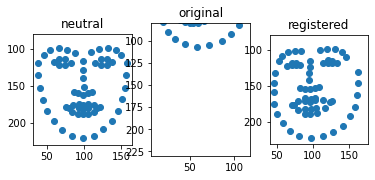

In [103]:
ix = 2020

f,axes = plt.subplots(1,3)
ax = axes[0]
ax.scatter(neutral[:,0], neutral[:,1])
ax.axis("square")
ax.set(ylim=[230,80], title="neutral")

# original
lms = landmarks.values[ix].reshape(2,68).T
ax = axes[1]
ax.scatter(lms[:,0], lms[:,1])
ax.axis("square")
ax.set(ylim=[230,80], title = "original")

# register
registered = registration(y[[ix]]).reshape(2,68).T
ax = axes[2]
ax.scatter(registered[:,0], registered[:,1])
ax.axis("square")
ax.set(ylim=[230,80], title = "registered")


In [ ]:
intensity = 1
aui = 14
au = np.zeros(clf_facet.n_components)
au[aui] = intensity
print(au)
predicted = predict(au, model=clf_facet).T
plt.scatter(predicted[:,0], predicted[:,1])

In [126]:
import seaborn as sns
sns.set_context('poster')

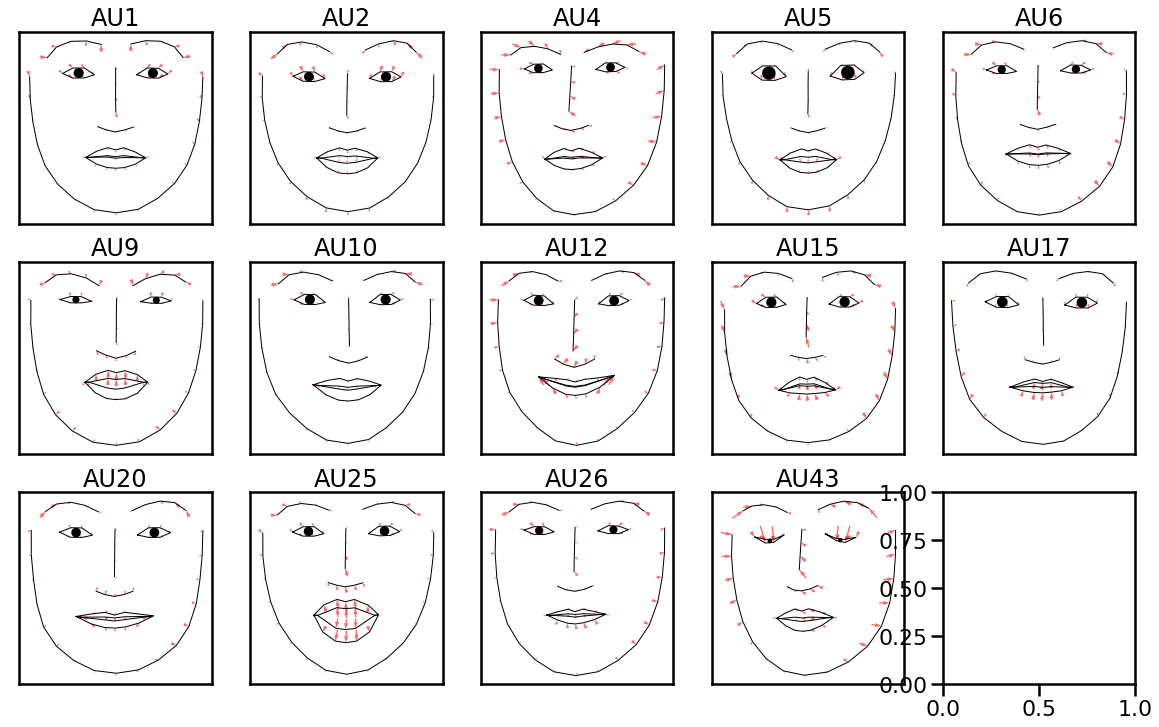

In [134]:
clf_facet.n_components

In [27]:
ax = axes[0]

In [28]:
ax.get_ylim()

(92.15024813348326, 226.09475384106187)

In [2]:
# load modules
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from feat.plotting import predict, plot_face
from feat.utils import registration
from natsort import natsorted

# Load data 
# Landmarks are extended CK images processed by OpenFace v 2.0
openface_dat  = pd.read_csv('ck_openface_data.csv')
facet_dat = pd.read_csv('ck_facet_data.csv')
facet_dat = facet_dat[natsorted(facet_dat.columns)]

# Train model with FACET AUs on OpenFace landmarks

N_comp: 23 Rsquare 0.61
3-fold accuracy mean 0.53


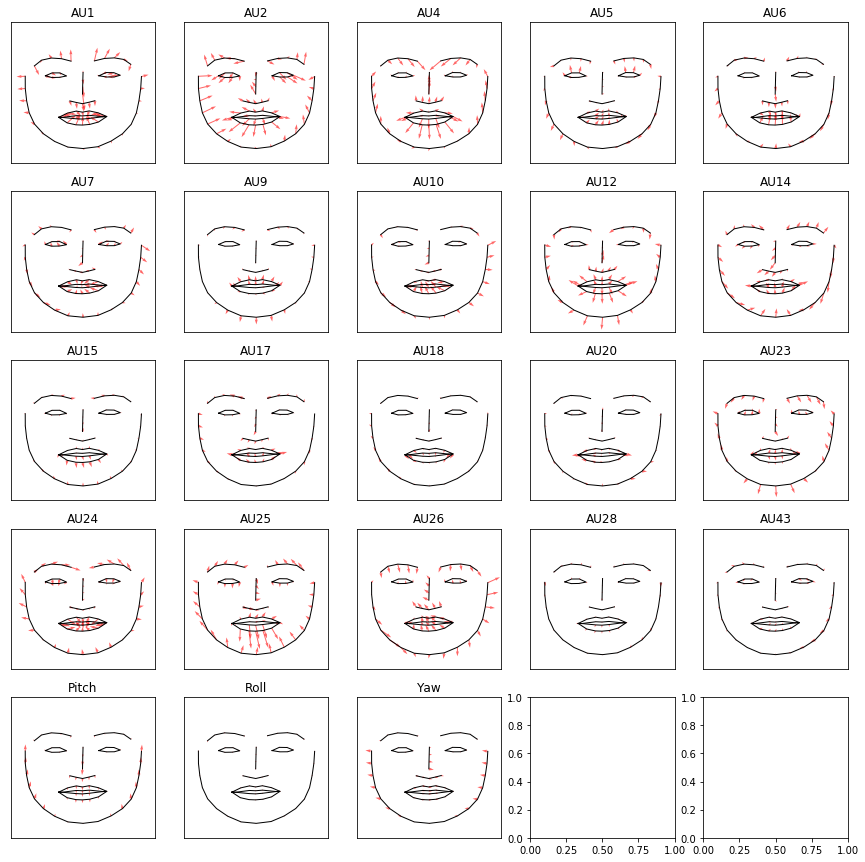

In [3]:
# Subset the landmark data 
lm_cols = ['x_'+str(i) for i in range(0,68)]+['y_'+str(i) for i in range(0,68)]
# Delete rows with na and mask each array
mask =np.any(~np.isnan(np.array(facet_dat)),axis=1)
X = np.array(facet_dat)[mask]
y = registration(openface_dat[lm_cols].as_matrix() [mask])

# Train model
n_components= np.shape(X)[1]
clf_facet = PLSRegression(n_components=n_components,max_iter=1000)
clf_facet.fit(X,y)
print('N_comp:',n_components,'Rsquare', np.round(clf_facet.score(X,y),2))
# Model Accuracy in KFold CV
kf = KFold(n_splits=3)
scores = []
for train_index, test_index in kf.split(X):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf_facet = PLSRegression(n_components=n_components)
    clf_facet.fit(X_train,y_train)
    scores.append(clf_facet.score(X_test,y_test))
print('3-fold accuracy mean', np.round(np.mean(scores),2))

# Plot results for each action unit
f,axes = plt.subplots(5,5,figsize=(15,15))
axes = axes.flatten()
intensity = 15
for aui, auname in enumerate(facet_dat.columns):
    au = np.zeros(len(clf_facet.x_mean_))
    au[aui] = intensity
    plot_face(au=np.zeros(n_components),model=clf_facet,vectorfield=
              {'target':predict(au,model=clf_facet),'color':'r','alpha':.6},
             ax = axes[aui])
    axes[aui].set(title=auname)

# Train model with OpenFace AUs on OpenFace landmarks

N_comp: 20 Rsquare 0.63
3-fold accuracy mean 0.49


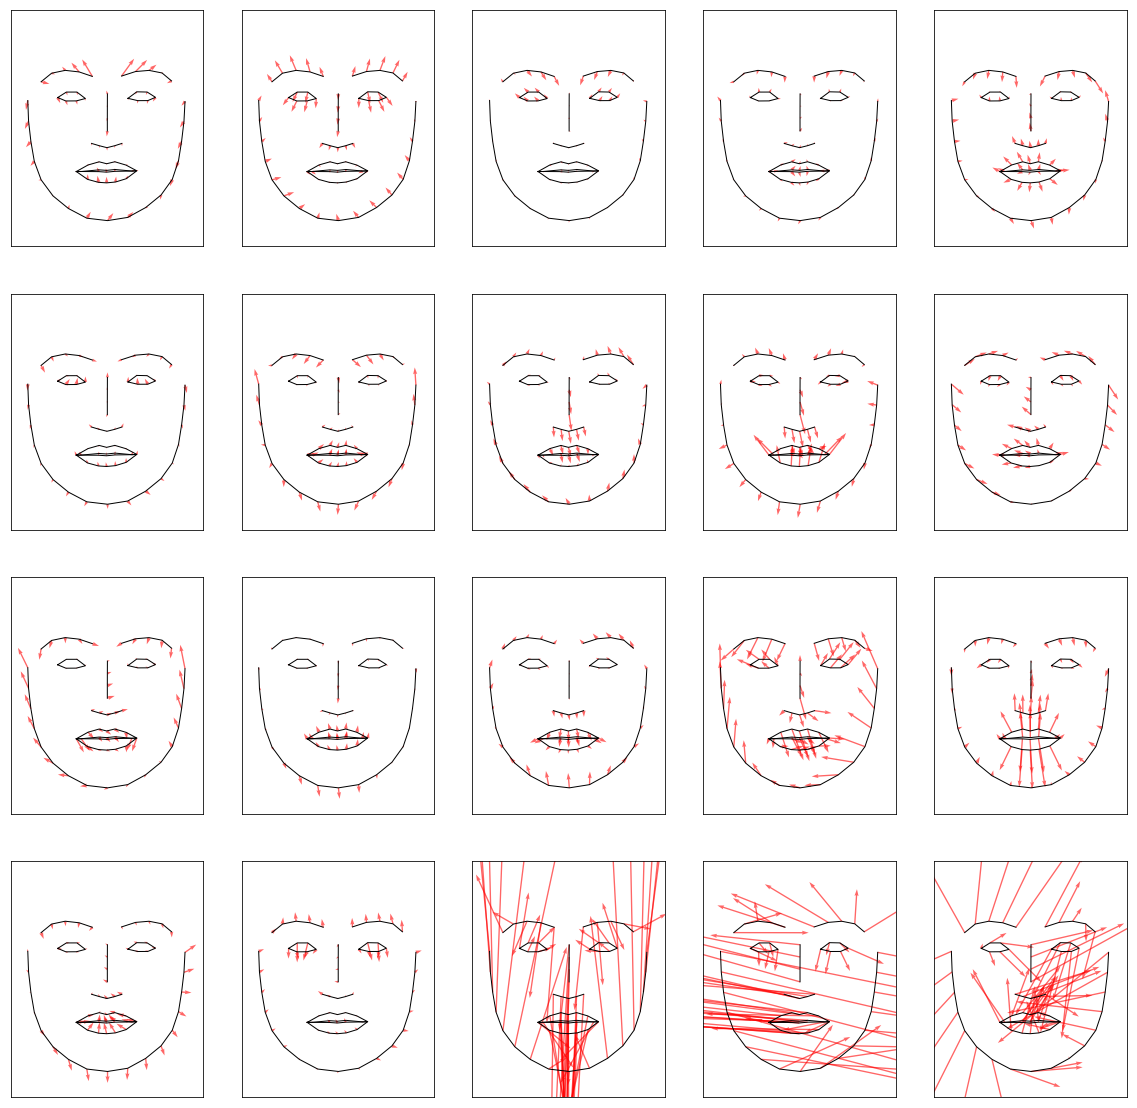

In [5]:
AUcols = [col for col in openface_dat.columns if 'AU' in col and '_r' in col]
AUcols.extend(['pose_Rx','pose_Ry','pose_Rz'])
# Delete rows with na and mask each array
mask = np.any(~np.isnan(np.array(openface_dat[AUcols])),axis=1)
X  = np.array(openface_dat[AUcols])[mask]
y = registration(openface_dat[lm_cols].as_matrix() [mask])

# Train model
n_components=np.shape(X)[1]
clf_facet = PLSRegression(n_components=n_components,max_iter=1000)
clf_facet.fit(X,y)
print('N_comp:',n_components,'Rsquare', np.round(clf_facet.score(X,y),2))
# Model Accuracy in KFold CV
kf = KFold(n_splits=3)
scores = []
for train_index, test_index in kf.split(X):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf_facet = PLSRegression(n_components=n_components)
    clf_facet.fit(X_train,y_train)
    scores.append(clf_facet.score(X_test,y_test))
print('3-fold accuracy mean', np.round(np.mean(scores),2))

# Plot results for each action unit
f,axes = plt.subplots(4,5,figsize=(20,20))
axes = axes.flatten()
intensity = 10
for aui, auname in enumerate(AUcols):
    au = np.zeros(len(clf_facet.x_mean_))
    au[aui] = intensity
    plot_face(au=np.zeros(n_components),model=clf_facet,vectorfield=
              {'target':predict(au,model=clf_facet),'color':'r','alpha':.6},
             ax = axes[aui])